<img src="https://heig-vd.ch/docs/default-source/doc-global-newsletter/2020-slim.svg" alt="HEIG-VD Logo" width="100" align="right" /> 

# Cours TAL - Laboratoire 4<br/>Reconnaissance des entités nommées

**Objectif**

L'objectif de ce travail est de comparer la reconnaissance des entités nommées (*named entity recognition*, NER) faite par quatre systèmes : NLTK, spaCy (deux modèles, 'en_core_web_sm' et 'en_core_web_lg'), et DistilBERT/NER.  Les données de test en anglais vous sont fournies sur Cyberlearn au format CoNLL.  Pour comparer les systèmes, on utilise la macro-moyenne des scores f1 pour chaque étiquette.  Vous pouvez concevoir l'ensemble du projet par vous-mêmes, ou suivre les indications suivantes.

## 1. NER avec spaCy et NLTK sur un texte court

In [1]:
import spacy
from spacy.tokens import Doc

In [2]:
# !python -m spacy download en_core_web_sm
# exécuter la ligne ci-dessus une fois, si nécessaire, idem pour en_core_web_lg

In [3]:
nlp = spacy.load("en_core_web_sm")

In [4]:
raw_text = "Reinhold Messner made a solo ascent of Mount Everest and was later a member of the European Parliament."

**1a.** Veuillez traiter ce texte avec la pipeline 'nlp', et pour chaque entité nommée trouvée veuillez afficher les mots qui la composent et son type.

In [5]:
docs = nlp(raw_text)
for ent in docs.ents:
    print(f"{ent.text} [{ent.label_}] - {type(ent)}")

Reinhold Messner [ORG] - <class 'spacy.tokens.span.Span'>
Mount Everest [LOC] - <class 'spacy.tokens.span.Span'>
the European Parliament [ORG] - <class 'spacy.tokens.span.Span'>


In [6]:
import nltk
# nltk.download('maxent_ne_chunker')
# nltk.download('words')
# exécuter les deux lignes ci-dessus une fois, si nécessaire

**1b.** Veuillez effectuer avec NLTK la tokenization, le POS tagging et le *NE chunking* de `raw_text` (voir la [documentation NLTK](https://www.nltk.org/api/nltk.chunk.ne_chunk.html#nltk.chunk.ne_chunk)).  Veuillez afficher le résultat et indiquer son type.

(S
  (PERSON Reinhold/NNP)
  (PERSON Messner/NNP)
  made/VBD
  a/DT
  solo/JJ
  ascent/NN
  of/IN
  (PERSON Mount/NNP Everest/NNP)
  and/CC
  was/VBD
  later/RB
  a/DT
  member/NN
  of/IN
  the/DT
  (ORGANIZATION European/NNP Parliament/NNP)
  ./.)
<class 'nltk.tree.tree.Tree'>


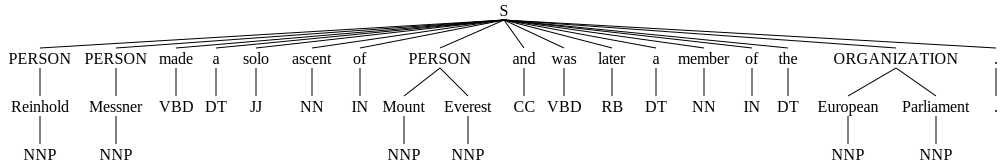

In [7]:
tokens = nltk.word_tokenize(raw_text)
pos_tags = nltk.pos_tag(tokens)
ne_tree = nltk.ne_chunk(pos_tags)

print(ne_tree)
print(type(ne_tree))

display(ne_tree)

**1c.** Veuillez afficher, pour chaque entité nommée, les mots qui la composent et son type.  Vous pouvez parcourir le résultat précédent avec une boucle `for`, et déterminer si un noeud possède une étiquette avec la fonction `hasattr(noeud, 'label')`.

In [8]:
for subtree in ne_tree:
    if hasattr(subtree, 'label'):
        print(subtree.label(), ' '.join([word for word, pos in subtree.leaves()]))

PERSON Reinhold
PERSON Messner
PERSON Mount Everest
ORGANIZATION European Parliament


**1d.** À ce stade, que pensez-vous de la qualité des résultats de chaque système ?

> spaCy semble correctement détecter l'Everest et le parlement européen, par contre Reinhold Messner est détecté comme une organisation ce qui n'est pas correct.
>
> NLTK détecte correctement Reinhold Messner mais sous deux branches différentes, le parlement européen est correctement nommé. Mais l'Everest est considéré comme une personne ce qui est évidemment faux.
>
> En résumé, les deux systèmes ont des résultats similaires, mais spaCy a quand même une meilleure précision sur les branches de l'arbre regroupant les entités nommées à nom composé.

## 2. Prise en main des données de test

**2a.** Quel est le format du fichier `eng.test.a.conll` ?  Quelle information contient chaque colonne ?  Quel est le format des tags NE ?

Note : ce fichier fait partie des données de test pour la NER sur l'anglais de la conférence [CoNLL](https://www.clips.uantwerpen.be/pages/past-workshops) 2003. On peut lire [ici](https://www.clips.uantwerpen.be/conll2003/ner/) la description de la tâche et les scores obtenus.  On peut trouver une copie des données [ici](https://sourceforge.net/p/text-analysis/svn/1243/tree/text-analysis/trunk/Corpora/CoNLL/2003/) ou [ici](https://github.com/synalp/NER/tree/master/corpus/CoNLL-2003).  Les textes proviennent du [corpus Reuters](http://trec.nist.gov/data/reuters/reuters.html).

> CoNLL-2003 spécialisé pour le named entity recognition
>
> 1. le mot
> 2. POS tag
> 3. syntactic chunk tag
> 4. named entity tag
>
> Les tags NE sont au format BIO (I-TYPE indiquent qu'un mot fait partie d'une entité nommée de type TYPE, et B-TYPE indique que le mot est le premier de l'entité nommée d'une nouvelle phrase si deux phrases du même type se suivent). O indique qu'il n'y a pas d'entité nommée.

**2b.** Veuillez charger les données de `eng.test.a.conll` grâce à la classe `ConllCorpusReader` de NLTK vue dans les labos précédents (voir [documentation](https://www.nltk.org/api/nltk.corpus.reader.conll.html#nltk.corpus.reader.conll.ConllCorpusReader)). Veuillez lire les colonnes qui contiennent les tokens ('words'), les POS tags ('pos') et les informations sur les entités nommées ('chunk') et afficher les quatre premières phrases, accessibles via la méthode `.iob_sents()`.

In [9]:
from nltk.corpus.reader.conll import ConllCorpusReader

In [10]:
corpus = ConllCorpusReader('.', 'eng.test.a.conll', ('words', 'pos', 'ignore', 'chunk'))

sentences = corpus.iob_sents()
for i in range(4):
    print(f"Phrase {i + 1}: {sentences[i]}")

Phrase 1: []
Phrase 2: [('CRICKET', 'NNP', 'O'), ('-', ':', 'O'), ('LEICESTERSHIRE', 'NNP', 'I-ORG'), ('TAKE', 'NNP', 'O'), ('OVER', 'IN', 'O'), ('AT', 'NNP', 'O'), ('TOP', 'NNP', 'O'), ('AFTER', 'NNP', 'O'), ('INNINGS', 'NNP', 'O'), ('VICTORY', 'NN', 'O'), ('.', '.', 'O')]
Phrase 3: [('LONDON', 'NNP', 'I-LOC'), ('1996-08-30', 'CD', 'O')]
Phrase 4: [('West', 'NNP', 'I-MISC'), ('Indian', 'NNP', 'I-MISC'), ('all-rounder', 'NN', 'O'), ('Phil', 'NNP', 'I-PER'), ('Simmons', 'NNP', 'I-PER'), ('took', 'VBD', 'O'), ('four', 'CD', 'O'), ('for', 'IN', 'O'), ('38', 'CD', 'O'), ('on', 'IN', 'O'), ('Friday', 'NNP', 'O'), ('as', 'IN', 'O'), ('Leicestershire', 'NNP', 'I-ORG'), ('beat', 'VBD', 'O'), ('Somerset', 'NNP', 'I-ORG'), ('by', 'IN', 'O'), ('an', 'DT', 'O'), ('innings', 'NN', 'O'), ('and', 'CC', 'O'), ('39', 'CD', 'O'), ('runs', 'NNS', 'O'), ('in', 'IN', 'O'), ('two', 'CD', 'O'), ('days', 'NNS', 'O'), ('to', 'TO', 'O'), ('take', 'VB', 'O'), ('over', 'IN', 'O'), ('at', 'IN', 'O'), ('the', 'DT',

**2c.** Veuillez préparer les données pour le test, en ne gardant que les phrases ayant au moins trois (3) tokens (pas 0, 1, 2) :

* une variable `test_tokens` contiendra les tokens groupés par phrase (liste de listes de strings)
* une variable `test_tags` contiendra tous les tags NE en une seule liste (en vue de l'évaluation)

In [11]:
test_tokens = []
test_tags = []

for sentence in sentences:
    if len(sentence) >= 3:
        test_tokens.append([word for word, _, _ in sentence])
        test_tags += [tag for _, _, tag in sentence]

**2d.** Combien d'occurrences de tags contient `test_tags`?  Combien de tags différents y a-t-il, et lesquels sont-ils ?  Combien il y a d'occurrences de tags de chaque type ?  Combien de phrases y a-t-il dans `test_tokens` ?

In [12]:
print(f"Nombre total de tags : {len(test_tags)}")
print(f"Nombre de phrases : {len(test_tokens)}")

unique_tags = list(set(test_tags))
print(f"Nombre de tags différents : {len(unique_tags)}")
print(f"Tags différents : {unique_tags}")
for tag in unique_tags:
    print(f"Nombre d'occurrences de {tag} : {test_tags.count(tag)}")

Nombre total de tags : 50817
Nombre de phrases : 2970
Nombre de tags différents : 5
Tags différents : ['I-ORG', 'O', 'I-PER', 'I-MISC', 'I-LOC']
Nombre d'occurrences de I-ORG : 2080
Nombre d'occurrences de O : 42474
Nombre d'occurrences de I-PER : 3097
Nombre d'occurrences de I-MISC : 1228
Nombre d'occurrences de I-LOC : 1938


## 3. Performances de NLTK pour la NER

**3a.** Le NER de NLTK a un jeu de tags différents de celui des données de test.  Veuillez chercher les informations pour compléter la fonction suivante qui convertit chaque tag du NER de NLTK vers le tag correspondant pour les données de test. 

In [13]:
def convert_nltk_conll(nltk_tag):
    corresp = {'O': 'O',
               'ORGANIZATION': 'I-ORG',
               'PERSON': 'I-PER',
               'LOCATION': 'I-LOC',
               'FACILITY': 'I-LOC',
               'GPE': 'I-LOC',  # Geo-Political Entity
               'GSP': 'I-MISC',  # Geo-Socio-Political group
               'MISC': 'I-MISC', }
    if nltk_tag in corresp:
        return corresp[nltk_tag]
    else:
        print(f"Tag inconnu : {nltk_tag}")
        return 'I-MISC'


**3b.** Veuillez exécuter la NER de NLTK sur chacune des phrases de `test_tokens`, ce qui assure que NLTK aura la même tokenisation que les données de référence.  Veuillez stocker les tags dans une liste unique appelée `nltk_tags`.

In [14]:
nltk_tags = []

for sentence in test_tokens:
    chunks = nltk.ne_chunk(nltk.pos_tag(sentence))
    for subtree in chunks:
        if hasattr(subtree, 'label'):
            nltk_tags += [subtree.label() for leaf in subtree.leaves()]
        else:
            nltk_tags.append('O')

**3c.** Veuillez convertir les tags de `nltk_tags` grâce à la fonction précédente, dans une liste appelée `nltk_tags_conv`.  Veuillez afficher le nombre total de tags et les dix premiers.  Vous pouvez plusieurs essais en changeant la fonction, pour aboutir à la conversion qui maximise le score.

In [15]:
nltk_tags_conv = [convert_nltk_conll(tag) for tag in nltk_tags]
print(f"Nombre total de tags : {len(nltk_tags_conv)}")
print(f"Dix premiers tags : {nltk_tags_conv[:10]}")

Nombre total de tags : 50817
Dix premiers tags : ['I-LOC', 'O', 'I-ORG', 'O', 'O', 'O', 'I-ORG', 'O', 'I-ORG', 'O']


**3d.** Veuillez afficher le rapport d'évaluation de classification obtenu de Scikit-learn et la matrice de confusion pour tous les types de tags apparaissant dans les données de test.

In [16]:
import numpy as np

def dummy_npwarn_decorator_factory():
    def npwarn_decorator(x):
        return x
    return npwarn_decorator

np._no_nep50_warning = getattr(np, '_no_nep50_warning', dummy_npwarn_decorator_factory)

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [37]:
print("Rapport d'évaluation :")
print(classification_report(test_tags, nltk_tags_conv, zero_division=0, digits=4))

Rapport d'évaluation :
              precision    recall  f1-score   support

       I-LOC     0.5451    0.7203    0.6206      1938
      I-MISC     0.1556    0.0057    0.0110      1228
       I-ORG     0.5094    0.3500    0.4149      2080
       I-PER     0.7671    0.7446    0.7557      3097
           O     0.9597    0.9891    0.9742     42474

    accuracy                         0.9140     50817
   macro avg     0.5874    0.5619    0.5553     50817
weighted avg     0.8943    0.9140    0.9012     50817



Matrice de confusion :
[[  728   717   377     5   253]
 [  144 42011    76     2   241]
 [  156   473  2306     2   160]
 [  187   438    85     7   511]
 [  214   137   162    29  1396]]


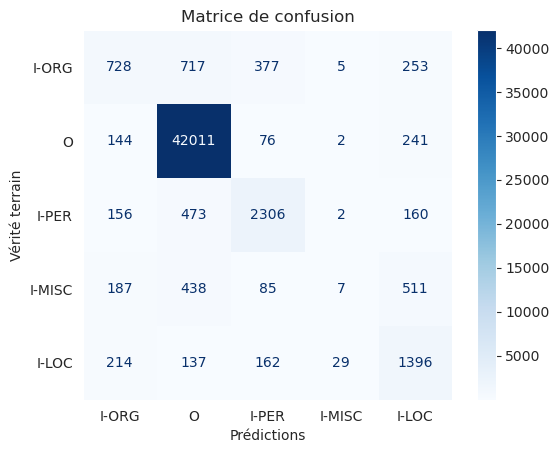

In [18]:
print("Matrice de confusion :")
confusion = confusion_matrix(test_tags, nltk_tags_conv, labels=unique_tags)
print(confusion)
disp = ConfusionMatrixDisplay(confusion, display_labels=unique_tags)
disp.plot(cmap='Blues')
plt.grid(False)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

## 4. Performances de spaCy pour la NER

**4a.** Le NER de spaCy a aussi un jeu de tags différents de celui des données de test.  Veuillez chercher les informations pour compléter la fonction suivante qui convertir chaque tag du NER de spaCy dans le tag correspondant pour les données de test.  Attention à la logique des conversions. 

In [19]:
def convert_spacy_conll(spacy_tag):
    corresp = {'O': 'O',
               'ORG': 'I-ORG',
               'PERSON': 'I-PER',
               'LOC': 'I-LOC',
               'FAC': 'I-LOC',  # Facility
               'GPE': 'I-LOC',  # Geo-Political Entity
               'NORP': 'I-MISC',  # Nationalities or religious or political groups
               'LAW': 'I-MISC',
               'PRODUCT': 'I-MISC',
               'EVENT': 'I-MISC',
               'WORK_OF_ART': 'I-MISC',
               'MONEY': 'O',
               'LANGUAGE': 'O',
               'DATE': 'O',
               'TIME': 'O',
               'QUANTITY': 'O',
               'PERCENT': 'O',
               'CARDINAL': 'O',
               'ORDINAL': 'O',
               }
    if spacy_tag in corresp:
        return corresp[spacy_tag]
    else:
        print(f"Tag inconnu : {spacy_tag}")
        return 'I-MISC'


> Note: il semblerait que spaCy définisse des entités beaucoup plus spécifiques que le format CoNLL-03 et NLTK comme par exemple les différents types de quantités (quantity, percent, cardinal, ordinal) et de temps (date, time). En comparant les scores obtenus après conversion. Nous pouvons donc de façon assez sure retirer les quantité et le temps en les traduisant comme "outside (O)", ceci car on peut déduire que ces entités ne sont pas considérées comme des entités nommées dans les deux résultats précédents.

**4b.** Veuillez exécuter la NER de spaCy sur chacune des phrases de `test_tokens`, ce qui assure que spaCy aura la même tokenisation que les données de référence.  Veuillez stocker les tags dans une liste unique appelée `spacy_tags`.

In [20]:
spacy_tags = []

for sentence in test_tokens:
    doc = nlp(Doc(nlp.vocab, sentence))
    for token in doc:
        if token.ent_iob == 2:
            spacy_tags.append('O')
        else:
            spacy_tags.append(token.ent_type_)

**4c.** Veuillez convertir les tags de `spacy_tags` grâce à la fonction précédente, dans une liste appelée `spacy_tags_conv`.  Veuillez afficher le nombre total de tags et les dix premiers.  Vous pouvez plusieurs essais en changeant la fonction, pour aboutir à la conversion qui maximise le score.

In [21]:
spacy_tags_conv = [convert_spacy_conll(tag) for tag in spacy_tags]
print(f"Nombre total de tags : {len(spacy_tags_conv)}")
print(f"Dix premiers tags : {spacy_tags_conv[:10]}")

Nombre total de tags : 50817
Dix premiers tags : ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


**4d.** Veuillez afficher le rapport d'évaluation de classification obtenu de Scikit-learn et la matrice de confusion pour tous les types de tags apparaissant dans les données de test.

In [36]:
print("Rapport d'évaluation :")
print(classification_report(test_tags, spacy_tags_conv, zero_division=0, digits=4))

Rapport d'évaluation :
              precision    recall  f1-score   support

       I-LOC     0.7925    0.8019    0.7971      1938
      I-MISC     0.6996    0.6107    0.6522      1228
       I-ORG     0.5233    0.5240    0.5237      2080
       I-PER     0.8268    0.7123    0.7653      3097
           O     0.9659    0.9786    0.9722     42474

    accuracy                         0.9282     50817
   macro avg     0.7616    0.7255    0.7421     50817
weighted avg     0.9263    0.9282    0.9268     50817



Matrice de confusion :
[[ 1090   527   224    41   198]
 [  435 41566   160   229    84]
 [  275   511  2206    26    79]
 [  147   251    34   750    46]
 [  136   178    44    26  1554]]


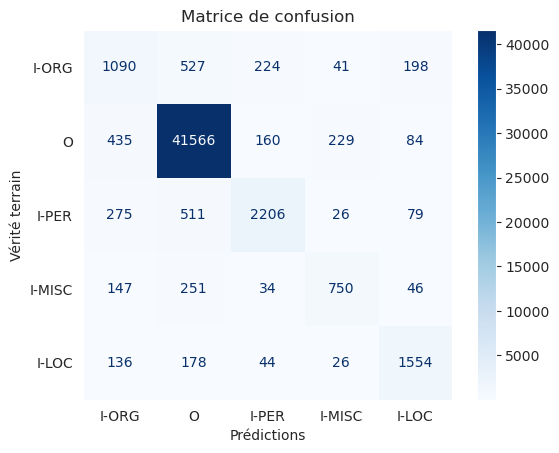

In [23]:
print("Matrice de confusion :")
confusion = confusion_matrix(test_tags, spacy_tags_conv, labels=unique_tags)
print(confusion)
disp = ConfusionMatrixDisplay(confusion, display_labels=unique_tags)
disp.plot(cmap='Blues')
plt.grid(False)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

**4e.** Veuillez exécuter également le modèle 'en_core_web_lg' de spacy et afficher le rapport d'évaluation (il n'est pas demander d'afficher la matrice de confusion).  Vous pouvez recopier ici le minimum de code nécessaire à l'obtention des résultats, avec une nouvelle pipeline spaCy appelée 'nlp2'.

In [35]:
# !python -m spacy download en_core_web_lg

nlp2 = spacy.load("en_core_web_lg")
spacy_tags2 = []
for sentence in test_tokens:
    doc = nlp2(Doc(nlp2.vocab, sentence))
    for token in doc:
        if token.ent_iob == 2:
            spacy_tags2.append('O')
        else:
            spacy_tags2.append(token.ent_type_)

spacy_tags_conv2 = [convert_spacy_conll(tag) for tag in spacy_tags2]

print("Rapport d'évaluation :")
print(classification_report(test_tags, spacy_tags_conv2, zero_division=0, digits=4))


Rapport d'évaluation :
              precision    recall  f1-score   support

       I-LOC     0.7541    0.8736    0.8095      1938
      I-MISC     0.8364    0.6580    0.7366      1228
       I-ORG     0.5519    0.6005    0.5752      2080
       I-PER     0.9134    0.8176    0.8628      3097
           O     0.9780    0.9803    0.9792     42474

    accuracy                         0.9430     50817
   macro avg     0.8068    0.7860    0.7926     50817
weighted avg     0.9447    0.9430    0.9432     50817



## 5. Utilisation d'embeddings contextualisés fournis par BERT

Dans cette section, vous allez évaluer un modèle basé sur le Transformer, qui fournit des embeddings contextualisés pour chaque token.  Ces embeddings sont ensuite utilisés par une couche finale (appelée _NER head_) pour assigner à chaque token une étiquette indiquant les entités nommées.  Le modèle et les instructions pour l'utiliser sont disponibles ici : https://huggingface.co/dslim/distilbert-NER (il s'agit d'une version de BERT "distillée" dans un modèle plus léger, suivi du _NER head_).

**5a.** Prise en main du modèle : à l'aide des exemples fournis sur Hugging Face, veuillez appliquer DistilBERT_NER sur les 3 premières phrases des données contenues dans `test_tokens` (voir le point 2c) et afficher les résultats obtenus.  Quelles sont les différences avec les résultats de NLTK et de spaCy ?

In [25]:
# Importer les trois classes, créer le tokenizer, le modèle et la pipeline.
from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

tokenizer = AutoTokenizer.from_pretrained("dslim/distilbert-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/distilbert-NER")

nlp_bert = pipeline("ner", model=model, tokenizer=tokenizer)

Device set to use cpu


In [26]:
# Tester la pipeline sur les 3 premières phrases de test_tokens : afficher la phrase et le résultat de la pipeline.
# Concaténer les tokens avec ' '.join(liste_de_tokens) avant de les donner à la pipeline.
for i in range(3):
    print(f"Phrase {i + 1}: {' '.join(test_tokens[i])}")
    res = nlp_bert(' '.join(test_tokens[i]))
    print(" ".join([f"{tag['word']} [{tag['entity']}-{tag['score']:.3f}]" for tag in res]))
    print()

Phrase 1: CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY .
L [B-PER-0.708] ##EI [B-PER-0.660] ##CE [B-PER-0.631] ##ST [B-PER-0.714] ##ER [B-PER-0.718] ##S [B-PER-0.810] ##H [B-PER-0.453] ##IR [B-PER-0.727] ##E [B-PER-0.762]

Phrase 2: West Indian all-rounder Phil Simmons took four for 38 on Friday as Leicestershire beat Somerset by an innings and 39 runs in two days to take over at the head of the county championship .
West [B-MISC-0.992] Indian [I-MISC-0.984] Phil [B-PER-0.999] Simmons [I-PER-0.999] Leicestershire [B-ORG-0.978] Somerset [B-ORG-0.991]

Phrase 3: Their stay on top , though , may be short-lived as title rivals Essex , Derbyshire and Surrey all closed in on victory while Kent made up for lost time in their rain-affected match against Nottinghamshire .
Essex [B-ORG-0.999] Derbyshire [B-ORG-0.998] Surrey [B-ORG-0.997] Kent [B-ORG-0.998] Nottinghamshire [B-ORG-0.995]



> Le modèle BERT donne des résultats sous forme de liste contenant uniquement les entités nommées, les tokens "O" sont omis. Il y a aussi une information supplémentaire contenant le score de certitude du réseau de neurone.
>
> On constate que le mot "LEICESTERSHIRE" tout en majuscule est inconnu du modèle et a donc été séparé en beaucoup de sous-tokens préfixés par "##" et le modèle a entièrement catégorisé ces sous-tokens comme "PER" ce qui est incorrect dans ce context. Le nommage du même mot dans la deuxième phrase a été fait correctement avec "ORG" quand on parle bien d'une équipe de sport.
>
> On notera aussi que "West Indian" a mien été taggé comme "MISC" et dans le modèle utilisé par spaCy pourrait être reconnu comme "NORP" (Nationalities or religious or political groups) ce qui est correct dans ce contexte car on parle bien du joueur Phil Simmons qui est un joueur de cricket des Antilles.
>
> Mis à part le mot en majuscule, on constate que les scores de certitude sont bons et que les entités nommées y correspondant sont correctes. Dans ce contexte où tous les noms de villes sont en faites les équipes de sport, ils ont tous été taggés comme "ORG", et leur séparation est faite correctement (avec le format BIO, Phil Simmons a bien été reconnu comme une seule entité, et les noms de villes appondus dans la troisième phrase ont bien été séparés avec trois fois B-ORG).

**5b.** Le modèle DistilBERT utilise son propre tokeniseur, c'est pourquoi les étiquettes indiquant les entités nommées sont parfois portées par plusieurs *subwords* composant un mot.  Il faut donc parfois agréger une liste d'étiquettes en une seule.  

Veuillez écrire une fonction qui prend en entrée une liste d'étiquettes et retourne une seule étiquette : soit la première, soit celle qui est majoritaire.  Cette fonction sera utilisée plus loin.

In [27]:
from collections import Counter

def tag_fusion(tag_list, method='first'):  # ou method='majority'
    if method == 'first':
        return tag_list[0]
    elif method == 'majority':
        return Counter(tag_list).most_common(1)[0][0]
    else:
        raise ValueError()

print(tag_fusion(['O', 'B-PER', 'B-PER'], method='majority'))

B-PER


**5c.** Veuillez afficher le `set` des tags apparaissant dans les résultats de DistilBERT_NER sur les 50 premières phrases du corpus.  Comment se comparent-ils aux tags des données de test CoNLL ?

In [28]:
bert_tags = []
for i in range(50):
    res = nlp_bert(' '.join(test_tokens[i]))
    bert_tags += [tag['entity'] for tag in res]

unique_bert_tags = set(bert_tags)
print(f"Nombre de tags différents : {len(unique_bert_tags)}")
print(f"Tags différents : {unique_bert_tags}")

Nombre de tags différents : 8
Tags différents : {'I-ORG', 'B-PER', 'B-LOC', 'I-PER', 'I-MISC', 'B-ORG', 'B-MISC', 'I-LOC'}


> Le modèle peut reconnaitre les entités de types suivantes: ORG, PER, LOC et MISC pour les éléments notables (comme typiquement la nationalité mentionné précédemment).
>
> Les tags sont formattés au format BIO (B- pour le début d'une entité et I- pour l'intérieur d'une entité).

**5d.**  Sur le modèle des points 3a et 4a, veuillez écrire une fonction qui convertit les tags générés par DistilBERT_NER aux tags des donnéees de test.  Vous utiliserez cette fonction plus loin.  

In [29]:
def convert_bert_conll(bert_tag):
    if bert_tag.startswith('B-'):
        return 'I-' + bert_tag[2:]

    return bert_tag

**5e.** La pipeline DistilBERT_NER utilise son propre tokeniseur, qui ne peut pas être changé, car le modèle DistilBERT a été défini et entraîné avec lui.  On doit donc convertir les tokens du modèle à la même tokenisation que celle des données de test, en vue de l'évaluation.  Pour cela, on vous donne la fonction `convert_tokens` ainsi que du code pour la tester.  Veuillez étudier le code pour pouvoir l'utiliser plus bas, puis répondez aux questions ci-après.

In [30]:
def convert_tokens(ref_tokens, bert_result, word_ids):
    tokenized = tokenizer.tokenize(' '.join(ref_tokens))
    all_tags = []
    for tok, i in zip(tokenized, range(len(tokenized))):
        label = [tag['entity'] for tag in bert_result if tag['index'] == i + 1]
        if label:
            label = label[0]
        else:
            label = 'O'
        if tok[:2] == '##' or word_ids[i] == word_ids[i - 1]:
            all_tags[-1].append(label)
        else:
            all_tags.append([label])
    return [tag_fusion(taglist, method='first') for taglist in all_tags]

In [31]:
# Test de la fonction convert_tokens:
i = 1  # choix de la phrase

def print_len(l):
    print(len(l), '--', l)

print_len(test_tokens[i])  # Affichage 1
tokenized_by_bert = tokenizer(test_tokens[i], add_special_tokens=False, is_split_into_words=True)
print_len(tokenizer.convert_ids_to_tokens(tokenized_by_bert["input_ids"]))  # Affichage 2
print_len(tokenized_by_bert.word_ids())  # Affichage 3
tagged_by_bert = nlp_bert(' '.join(test_tokens[i]))
print_len(tagged_by_bert)  # Affichage 4
print_len(convert_tokens(test_tokens[i], tagged_by_bert, tokenized_by_bert.word_ids()))  # Affichage 5

35 -- ['West', 'Indian', 'all-rounder', 'Phil', 'Simmons', 'took', 'four', 'for', '38', 'on', 'Friday', 'as', 'Leicestershire', 'beat', 'Somerset', 'by', 'an', 'innings', 'and', '39', 'runs', 'in', 'two', 'days', 'to', 'take', 'over', 'at', 'the', 'head', 'of', 'the', 'county', 'championship', '.']
38 -- ['West', 'Indian', 'all', '-', 'round', '##er', 'Phil', 'Simmons', 'took', 'four', 'for', '38', 'on', 'Friday', 'as', 'Leicestershire', 'beat', 'Somerset', 'by', 'an', 'innings', 'and', '39', 'runs', 'in', 'two', 'days', 'to', 'take', 'over', 'at', 'the', 'head', 'of', 'the', 'county', 'championship', '.']
38 -- [0, 1, 2, 2, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34]
6 -- [{'entity': 'B-MISC', 'score': np.float32(0.99248767), 'index': 1, 'word': 'West', 'start': 0, 'end': 4}, {'entity': 'I-MISC', 'score': np.float32(0.9836287), 'index': 2, 'word': 'Indian', 'start': 5, 'end': 11}, {'entity': 'B-PER', 's

#### Questions

1. Que représentent les trois paramètres de convert_tokens ? Définissez-les comme dans une docstring.
   > - `ref_tokens`: liste des tokens de référence (i.e. la phrase complète du corpus CoNLL séparée en mots dans une liste)
   > - `bert_result`: liste des résultats de la pipeline DistilBERT_NER au format mentionné précédemment
   > - `word_ids`: liste des indices des tokens de référence dans le tokeniseur DistilBERT
2. Que représentent les cinq lignes affichées par le code de test ?
   > 1. Affichage 1: la phrase originale (tokens de référence)
   > 2. Affichage 2: les tokens de la phrase originale après tokenisation par le modèle DistilBERT (on constate la longueur légeremment différente car le mot "all-rounder" a été séparé en plusieurs sous-tokens)
   > 3. Affichage 3: les indices des tokens de référence dans le tokeniseur DistilBERT (on constate ici que le mot "all-rounder" est maintenu à l'indice 2 pour ses 4 sous-tokens "all", "-", "round", "##er")
   > 4. Affichage 4: les résultats de la pipeline DistilBERT_NER sur la phrase originale (qui sera tokenisée par le même tokenizer)
   > 5. Affichage 5: les résultats de la fonction convert_tokens sur la phrase originale (tokenisée par le même tokenizer), qui sont les tags de référence après conversion (i.e. le résultat final de la pipeline DistilBERT_NER) et incluent les tags "O" pour les tokens qui ne sont pas des entités nommées, les tokens décomposés par le tokenizer de BERT ont aussi été fusionnés et on retrouve la longueur de la phrase originale.
3. Quels sont les deux problèmes traités par la fonction convert_tokens ?
   > - La gestion des tokens qui sont décomposés en plusieurs sous-tokens connus par le vocabulaire du modèle
   > - La reconstruction en un seul token en prenant le premier tag de la liste de ces tokens décomposés
   > - L'inclusion des tags "O" pour les tokens qui ne sont pas donnés comme des entités nommées par la pipeline


**5f.** Veuillez effectuer la reconnaissance des entités nommées avec la pipeline DistilBERT_NER et obtenir la liste finale de tags avec les noms convertis à ceux du jeu de référence grâce à `convert_bert_conll`.

In [32]:
j = len(test_tokens)  # se limiter aux j premières phrases sur les 2970 (utile pendant le développement, mais les utiliser toutes à la fin)

def handle_sentence(sentence):
    tokenized_by_bert = tokenizer(sentence, add_special_tokens=False, is_split_into_words=True)
    bert_result = nlp_bert(' '.join(sentence))
    return convert_tokens(sentence, bert_result, tokenized_by_bert.word_ids())

bert_tags = []
for i in range(j):
    res = handle_sentence(test_tokens[i])
    bert_tags += res

bert_tags_conv = [convert_bert_conll(tag) for tag in bert_tags]

print(len(bert_tags_conv))

50817


**5g.** En comparant `test_tags` avec `bert_tags_conv`, veuillez afficher le rapport d'évaluation de la classification et la matrice de confusion, pour tous les types de tags apparaissant dans les données de test.

In [33]:
print("Rapport d'évaluation :")
print(classification_report(test_tags, bert_tags_conv, zero_division=0, digits=4))

Rapport d'évaluation :
              precision    recall  f1-score   support

       I-LOC     0.9551    0.9556    0.9554      1938
      I-MISC     0.9072    0.8917    0.8994      1228
       I-ORG     0.9319    0.9279    0.9299      2080
       I-PER     0.9787    0.9803    0.9795      3097
           O     0.9968    0.9973    0.9971     42474

    accuracy                         0.9893     50817
   macro avg     0.9540    0.9506    0.9522     50817
weighted avg     0.9893    0.9893    0.9893     50817



Matrice de confusion :
[[ 1930    40    34    41    35]
 [   40 42361     8    47    18]
 [   19    23  3036     7    12]
 [   42    56    13  1095    22]
 [   40    18    11    17  1852]]


<Figure size 1000x700 with 0 Axes>

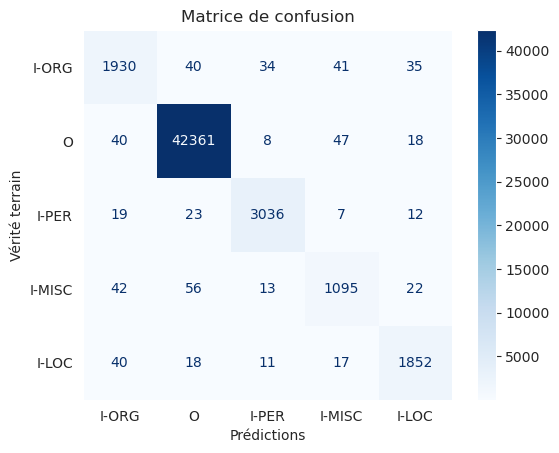

In [34]:
print("Matrice de confusion :")
confusion = confusion_matrix(test_tags, bert_tags_conv, labels=unique_tags)
print(confusion)
plt.figure(figsize=(10, 7))
disp = ConfusionMatrixDisplay(confusion, display_labels=unique_tags)
disp.plot(cmap='Blues')
plt.grid(False)
plt.xlabel('Prédictions')
plt.ylabel('Vérité terrain')
plt.title('Matrice de confusion')
plt.show()

**5h.** Laquelle des deux stratégies de `tag_fusion` (premier tag ou tag majoritaire) conduit à de meilleurs résultats ?  Veuillez effectuer l'expérience et indiquer simplement les scores obtenus et votre conclusion dans le champ suivant.  Pour la conclusion finale, gardez 'first'.

#### Avec le premier tag
```
Rapport d'évaluation :
              precision    recall  f1-score   support

       I-LOC     0.9551    0.9556    0.9554      1938
      I-MISC     0.9072    0.8917    0.8994      1228
       I-ORG     0.9319    0.9279    0.9299      2080
       I-PER     0.9787    0.9803    0.9795      3097
           O     0.9968    0.9973    0.9971     42474

    accuracy                         0.9893     50817
   macro avg     0.9540    0.9506    0.9522     50817
weighted avg     0.9893    0.9893    0.9893     50817
```

#### Avec le tag majoritaire
```
Rapport d'évaluation :
              precision    recall  f1-score   support

       I-LOC     0.9571    0.9561    0.9566      1938
      I-MISC     0.9073    0.8925    0.8998      1228
       I-ORG     0.9319    0.9274    0.9296      2080
       I-PER     0.9784    0.9797    0.9790      3097
           O     0.9968    0.9974    0.9971     42474

    accuracy                         0.9894     50817
   macro avg     0.9543    0.9506    0.9524     50817
weighted avg     0.9893    0.9894    0.9893     50817
```

#### Conclusion

Dans l'ensemble, les résultats sont pratiquement identiques et se constatent seulement si le nombre de décimales est augmenté. Cela se constate également en lisant la moyenne macro, qui mesure la différence entre les deux méthodes dans l'ordre du millième. On peut donc conclure que la méthode de la majorité est légèrement meilleure, mais que la différence est négligeable. Comme cette méthode requiert quand même l'utilisation d'un compteur pour déterminer la majorité, il est plus efficace d'utiliser la première méthode qui est plus rapide et ne nécessite pas de calcul supplémentaire.

## 6. Discussion finale

Veuillez comparer les scores des quatre modèles testés, en termes de **macro avg**.  Pourquoi ce score est-il le plus informatif ?  Veuillez indiquer également la taille des modèles spaCy évalués.

|               | NLTK   | spaCy sm | spaCy LG | DistilBERT |
|---------------|--------|----------|----------|------------|
| **macro avg** | 0.5553 | 0.7421   | 0.7926   | 0.9522     |
| **taille**    |        | 12 Mo    | 382 Mo   |            |

> Le macro avg est une moyenne qui n'est pas pondérée par le nombre d'éléments de chaque classe. Comme notre dataset contient 42474/50817 tokens qui ne font pas partie d'entités nommées, cela fait 83.6% de tokens qui sont des "O". Si nous utilisons la moyenne pondérée, le score sera biaisé par cette classe.
>
> Le score macro avg est donc plus informatif car il permet de voir la performance du modèle sur chaque classe indépendamment de la taille de celle-ci. On peut aussi voir que le modèle DistilBERT est bien meilleur que les autres modèles, et que le modèle spaCy lg est meilleur que le modèle spaCy sm, mais pas de beaucoup.
>
> NLTK est le modèle qui performe le moins bien, en partie parce que cette librairie utilise un modèle de machine learning traditionnel (maxent) qui est moins performant que les modèles basés sur des réseaux de neurones. De plus, il n'y a pas de pré-entrainement sur un corpus spécifique pour le NER. Le corpus utilisé pour l'entrainement est aussi plus petit et arrivera moins à généraliser sur des données inconnues.
>
> spaCy performe mieux, avec une moyenne à 0.74 pour le modèle sm et 0.79 pour le modèle lg. Ces scores sont légèrement plus bas que ceux spécifiés dans la documentation (respectivement, 0.84 et 0.86). À nouveau, cette différence est sûrement dûe à la différence des corpus utilisés pour l'entrainement. On constate également que le modèle lg, qui est 30 fois plus lourd que le modèle sm, n'apporte pas une grande différence de performance.
>
> DistilBERT est le modèle le plus performant, avec un score de 0.95. Ce modèle est basé sur un transformer et a été pré-entrainé sur le même corpus que nous avons utilisé pour comparer les résultats entre tous les modèles (CoNLL-03). L'utilisation d'un réseau de neurones permet au modèle d'apprendre des relations entre les mots et de mieux généraliser sur des données inconnues. On peut quand même estimer qu'une partie des performances constatée est dûe à l'utilisation d'un corpus lors de l'entrainement qui est contextuellement proche de celui utilisé dans nos évaluations et donc émettre quelques réserves sur la performance de généralisation du modèle.


**Fin du Labo.** Veuillez nettoyer ce notebook en gardant seulement les résultats désirés, l'enregistrer, et le soumettre comme devoir sur Cyberlearn.